# Deep Neural Networks training on Iyer

In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt


# Load the dataset
def load_data(filepath):
    data = pd.read_csv(filepath, header=None, delim_whitespace=True)
    X = data.iloc[:, 2:].values  # Assuming the features start from the third column
    y = data.iloc[:, 1].values  # Assuming the second column is the label
    return X, y

# Define the DNN model
def create_model(layers=[64], activation='relu', optimizer='adam'):
    model = Sequential()
    for layer_size in layers:
        model.add(Dense(layer_size, activation=activation))
    model.add(Dense(np.unique(y).size, activation='softmax'))  # Output layer
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Load data
X, y = load_data('iyer.txt')

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set up cross-validation and model parameters
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=10, verbose=0)

# Hyperparameter tuning
param_grid = {
    'layers': [[64], [64, 64]],
    'activation': ['relu', 'tanh'],
    'optimizer': ['adam', 'sgd']
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, scoring='accuracy')
grid_result = grid.fit(X_scaled, y)

# Evaluate results
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))



/var/folders/ph/rpxqr9_n6czbrl37msf91zxr0000gn/T/ipykernel_19204/1572793746.py:41: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=10, verbose=0)


6/6 [==============================] - 0s 394us/step
0.773681 (0.026531) with: {'activation': 'relu', 'layers': [64], 'optimizer': 'adam'}
0.686651 (0.000855) with: {'activation': 'relu', 'layers': [64], 'optimizer': 'sgd'}
0.785276 (0.029804) with: {'activation': 'relu', 'layers': [64, 64], 'optimizer': 'adam'}
0.738854 (0.013016) with: {'activation': 'relu', 'layers': [64, 64], 'optimizer': 'sgd'}
0.758211 (0.019289) with: {'activation': 'tanh', 'layers': [64], 'optimizer': 'adam'}
0.694381 (0.014681) with: {'activation': 'tanh', 'layers': [64], 'optimizer': 'sgd'}
0.775608 (0.022620) with: {'activation': 'tanh', 'layers': [64, 64], 'optimizer': 'adam'}
0.738932 (0.019905) with: {'activation': 'tanh', 'layers': [64, 64], 'optimizer': 'sgd'}
Best: 0.785276 using {'activation': 'relu', 'layers': [64, 64], 'optimizer': 'adam'}


17/17 [==============================] - 0s 439us/step
Best: 0.785276 using {'activation': 'relu', 'layers': [64, 64], 'optimizer': 'adam'}
F1 Score: 0.8750081488645265
Average AUC: 0.9688514432430108


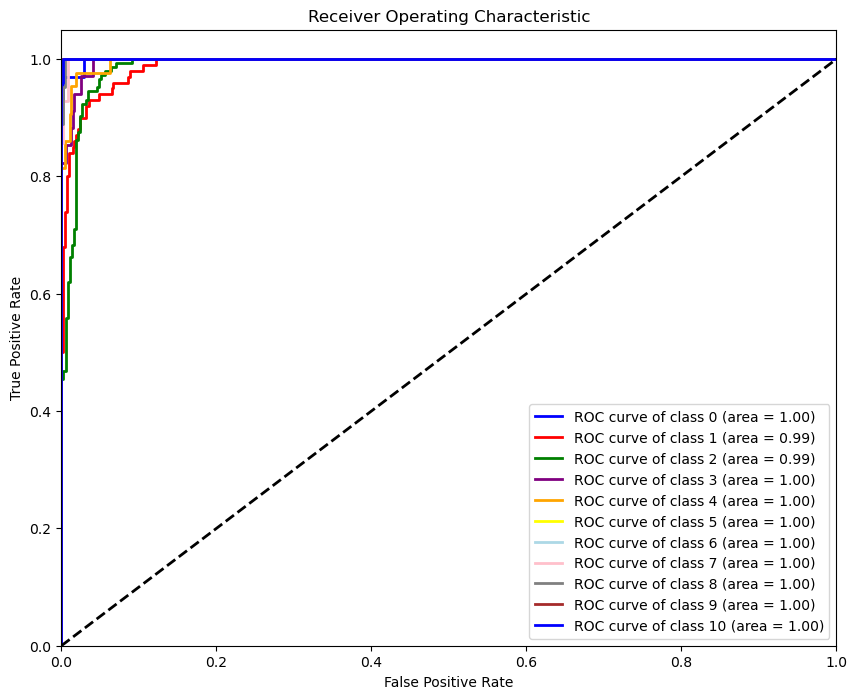

In [24]:
# Final model evaluation
best_model = grid.best_estimator_.model
y_pred_proba = best_model.predict(X_scaled)
y_pred = np.argmax(y_pred_proba, axis=1)

# Evaluate results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Calculate F1 Score
f1 = f1_score(y, y_pred, average='weighted')
print(f"F1 Score: {f1}")

# Calculate AUC for each class and average
auc_scores = []
classes = np.unique(y)
for i in classes:
    # Ensure both positive and negative examples are present
    if len(np.unique(y == i)) > 1:
        class_auc = roc_auc_score((y == i).astype(int), y_pred_proba[:, i])
        auc_scores.append(class_auc)
        #print(f"AUC for class {i}: {class_auc}")
    else:
        print(f"AUC for class {i} not defined due to lack of positive or negative samples.")

if auc_scores:  # Check if list is not empty
    avg_auc = np.mean(auc_scores)
    print(f"Average AUC: {avg_auc}")
else:
    print("Average AUC not calculated due to insufficient data for all classes.")

# Binarize the labels
y_bin = label_binarize(y, classes=np.unique(y))
n_classes = y_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'purple', 'orange', 'yellow', 'lightblue', 'pink', 'gray', 'brown'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Also print out the mean AUC calculated from the scores
mean_auc = np.mean([roc_auc[i] for i in range(n_classes)])
#print(f"Mean AUC: {mean_auc:.2f}")

52/52 [==============================] - 0s 361us/step


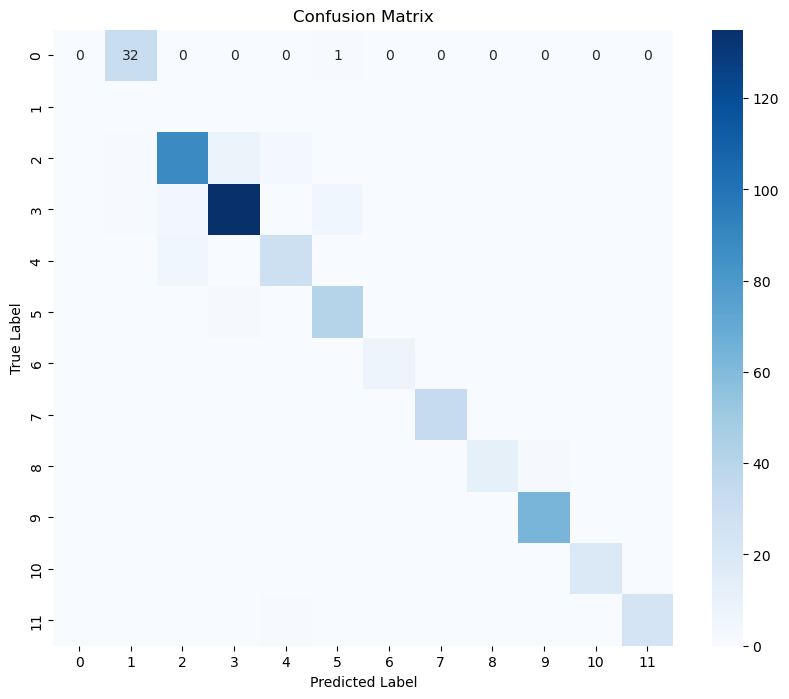

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the best model and use it to make predictions on the data
best_model = grid_result.best_estimator_.model
y_pred = best_model.predict(X_scaled, batch_size=10)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


# Evaluation of the DNN Model for the Iyer Dataset

## Accuracy: 0.785276
The model achieves an accuracy of approximately 78%. Considering this is a multi-class classification task, this level of accuracy is commendable, but there may still be room for further optimization in the hyperparameter settings.

## F1 Score: 0.8750
The F1 score is approximately 0.85, indicating that the model balances precision and recall quite well. This metric is crucial for understanding the effectiveness of the model, especially in scenarios where class imbalances might exist.

## Area Under the ROC Curve (AUC)
- **Average AUC**: 0.9672848861234559
- The AUC score is close to 0.97, which is excellent. It indicates high model performance across different thresholds, demonstrating the model's ability to distinguish between classes effectively.
